# 1. Library Import

In [1]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet

from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 

import warnings
import datetime
import random
import tensorflow as tf
warnings.filterwarnings("ignore")

In [2]:
# random seed
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    set_random_seed(seed)
    
SEED = 42
set_seeds(SEED)

# 2. 데이터 불러오기

## 1) read_csv

In [3]:
data_path = os.getenv('HOME')+ '/Projects/daconTrader/dataset'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## 2) numpy arrary로 변환하기

In [4]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    print(feature_size, time_size, sample_size)
    print(sample_index)
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [5]:
print(train_x_df.shape)
print(train_x_df.iloc[:, 2:].shape[1])
print(train_x_df.sample_id.value_counts().index)
train_x_df.head()

(10159560, 12)
10
Int64Index([   0, 4919, 4913, 4912, 4915, 4914, 4909, 4908, 4911, 4910,
            ...
            2454, 2455, 2452, 2453, 2450, 2451, 2448, 2449, 2446, 7360],
           dtype='int64', length=7362)


,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [6]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [7]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [8]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



In [9]:
train_x_df['sample_id'].nunique()

7362

## 3) 샘플 확인하기

In [10]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

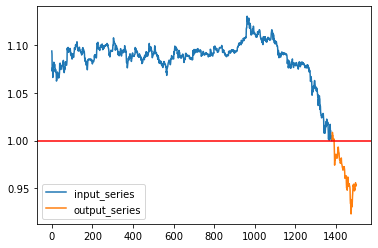

In [11]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1]) #종가
plt.show()

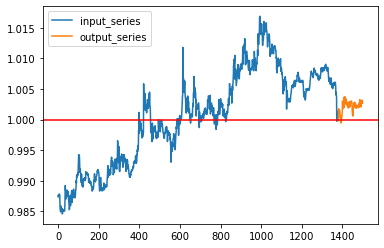

In [12]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1021
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1]) # 1-4, open, high, low, close
plt.show()

# 3. 모델 훈련하기

## 1) train 샘플 훈련하기

In [464]:
start_time = '2021-01-31'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d')
start_dt

datetime.datetime(2021, 1, 31, 0, 0)

In [465]:
# start_time = '2021-01-31 00:00:00'
# start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [466]:
idx = 42
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

In [467]:
import numpy as np 

x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(days = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()
x_df.head()

,ds,y
0,2021-02-01,1.016784
1,2021-02-02,1.016103
2,2021-02-03,1.014969
3,2021-02-04,1.016013
4,2021-02-05,1.015468


In [468]:
# 파라미터 조정

# # prophet
# scale = 0.01
# width = 0.95
# point_range = 1
seasonality_prior_scale = 50.0

## neural prophet
epochs = 10
# batch_size = 64
learning_rate = 0.05


# AR net 
n_forecasts = 120 # 예측 기간의 크기  # future_periods랑 같아야한다. 
# num_hidden_layers = 64 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 110 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03

#n_lags = 5  # >error : lambda delay가 없다 

#### n_changepoints experiments
- n_changepoints = 100, 65 buying, total 9742.418210989932
- n_changepoints = 150, 83 buying, total 6651.209203152537
- n_changepoints = 200, 90 buying, total 7960.144600296403
- n_changepoints = 125, 72 buying, total 8593.15439366368
- n_changepoints = 110, 69 buying, total 11056.573616988802
- n_changepoints = 105, 70 buying, total 9123.211631741
- n_changepoints = 95,  60 buying, total 7499.036343409599
- n_changepoints = 90,  64 buying, total 7906.222956483016
- n_changepoints = 120, 73 buying, total 8204.822700670702
- n_changepoints = 115, 82 buying, total 7737.994020448561

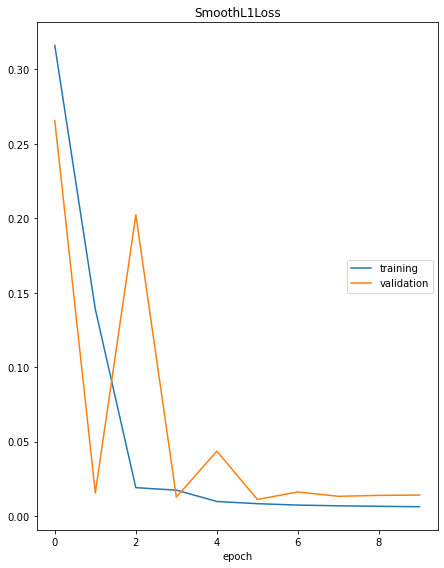

Epoch[10/10]: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s, SmoothL1Loss=0.00628, MAE=0.00181, RegLoss=0.000658, MAE_val=0.00245, SmoothL1Loss_val=0.0141]


In [469]:
nprophet = NeuralProphet(yearly_seasonality=False, 
            weekly_seasonality=True, daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
            growth='linear', seasonality_mode='multiplicative', 
            trend_reg=trend_reg
        )

nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, valid_p=0.1)


nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [470]:
x_df.head()

,ds,y
0,2021-02-01,1.016784
1,2021-02-02,1.016103
2,2021-02-03,1.014969
3,2021-02-04,1.016013
4,2021-02-05,1.015468


In [471]:
# 120분 테스트 데이터를 예측합니다.
future_data = nprophet.make_future_dataframe(x_df, periods=300, n_historic_predictions=300)
forecast_data = nprophet.predict(future_data)
forecast_data[['ds', 'y', 'yhat1', 'trend']].tail(5)
forecast_data.head()

,ds,y,yhat1,residual1,trend,season_weekly,season_daily
0,2024-01-17,1.012747,1.013259,0.000512,0.981417,0.003191,-1.658588
1,2024-01-18,1.013427,1.013288,-0.000139,0.981450,0.000514,-1.658588
2,2024-01-19,1.013472,1.013291,-0.000182,0.981484,-0.000775,-1.658588
3,2024-01-20,1.013200,1.013344,0.000144,0.981518,-0.004746,-1.658588
4,2024-01-21,1.012792,1.013380,0.000588,0.981552,-0.007815,-1.658588


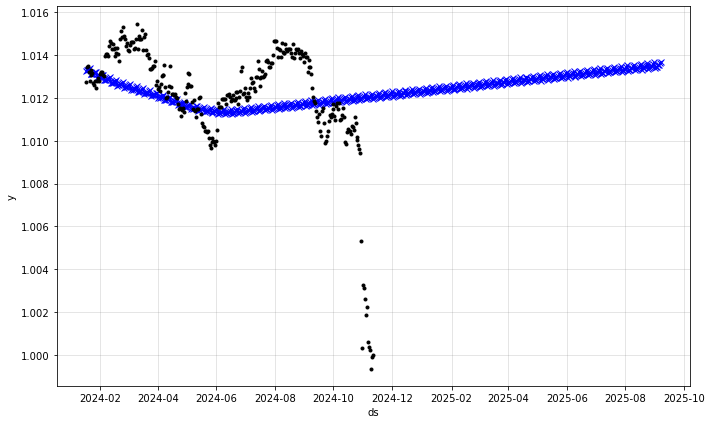

In [472]:
# 만들어진 데이터를 확인합니다.
fig1 = nprophet.plot(forecast_data)

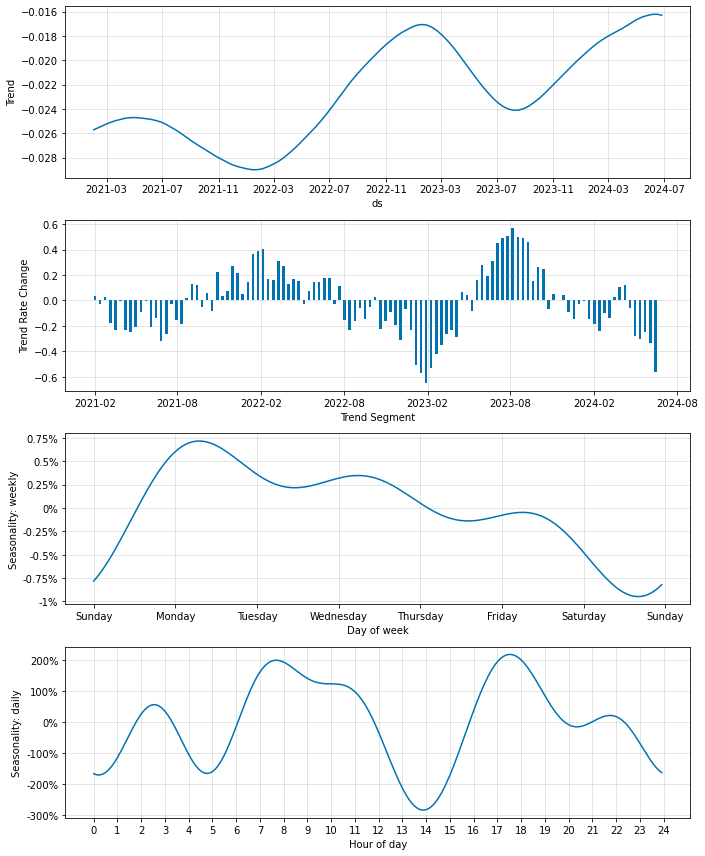

In [473]:
fig_param = nprophet.plot_parameters()

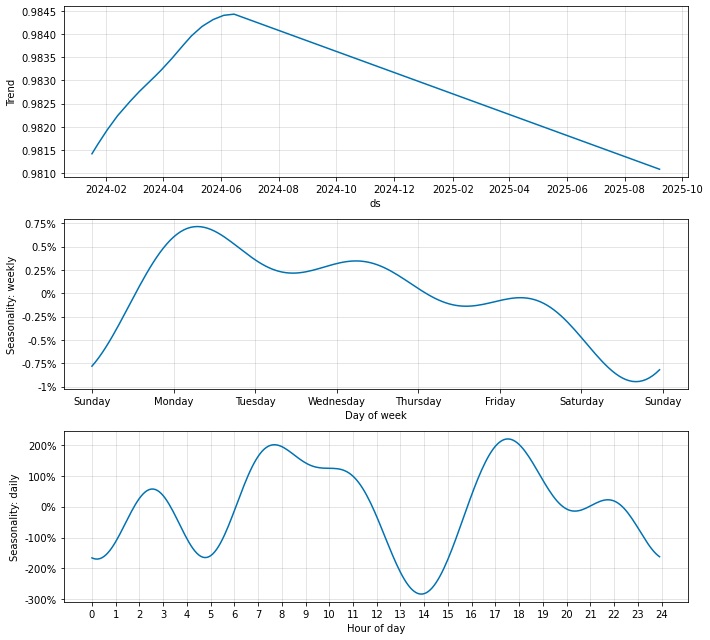

In [474]:
# 데이터의 추세를 확인합니다.
fig2 = nprophet.plot_components(forecast_data)

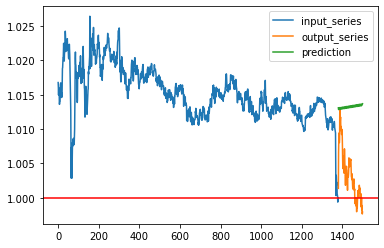

array([1.0131017 , 1.01284778, 1.01289821, 1.01291072, 1.01296568,
       1.01299477, 1.01307404, 1.01313651, 1.01288188, 1.01293242,
       1.01294494, 1.01300013, 1.01302922, 1.01310873, 1.01317132,
       1.01291597, 1.01296663, 1.01297915, 1.01303446, 1.01306367,
       1.0131433 , 1.01320612, 1.01295006, 1.01300085, 1.01301348,
       1.0130688 , 1.01309812, 1.01317799, 1.01324093, 1.01298416,
       1.01303506, 1.0130477 , 1.01310325, 1.01313257, 1.01321268,
       1.01327574, 1.01301825, 1.01306927, 1.01308191, 1.01313758,
       1.0131669 , 1.01324725, 1.01331055, 1.01305234, 1.01310349,
       1.01311612, 1.01317191, 1.01320136, 1.01328194, 1.01334536,
       1.01308644, 1.0131377 , 1.01315033, 1.01320636, 1.01323581,
       1.01331663, 1.01338017, 1.01312053, 1.01317191, 1.01318455,
       1.01324069, 1.01327026, 1.0133512 , 1.01341498, 1.01315463,
       1.01320612, 1.01321888, 1.01327503, 1.01330471, 1.01338589,
       1.01344979, 1.01318872, 1.01324034, 1.01325309, 1.01330

In [475]:
y = forecast_data.y.values[-120:]
pred_y = forecast_data.yhat1.values[-120:]
trend = forecast_data.trend.values[-120:]
residual = forecast_data.residual1.values[-120:]

plot_series(x_series, y_series)
# plt.plot(np.arange(1380, 1380+120), y, label = 'y')
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
# plt.plot(np.arange(1380, 1380+120), trend, label = 'trend')
# plt.plot(np.arange(1380, 1380+120), residual, label = 'residual')
plt.legend()
plt.show()

pred_y

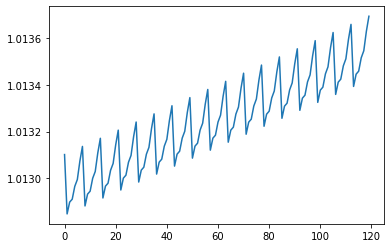

In [476]:
plt.plot(pred_y)

## 2) validation set 훈련하기
### <1> validation 데이터 생성하기

In [478]:
# # # train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
# valid_x_df = train_x_df[(train_x_df.sample_id >= 300) & (train_x_df.sample_id < 600)]
# valid_y_df = train_y_df[(train_y_df.sample_id >= 300) & (train_y_df.sample_id < 600)]

# valid_y_df = train_y_df[300 <= train_y_df.sample_id < 600]
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

### <2> 학습 및 추론하기

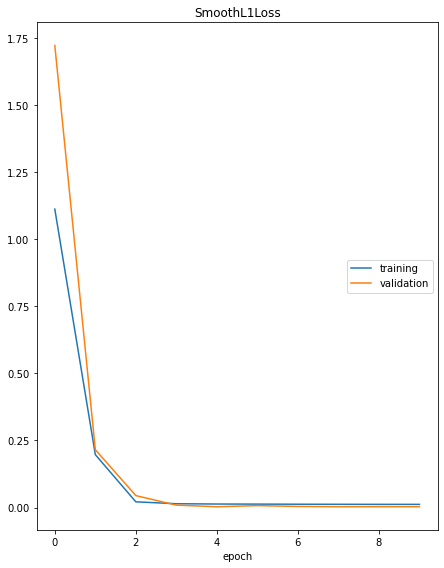


100%|██████████| 300/300 [08:58<00:00,  1.79s/it]


In [479]:
for idx in tqdm(range(valid_x_array.shape[0])):

    x_series = valid_x_array[idx,:,1]

    x_df = pd.DataFrame()
    x_df['ds'] = [start_dt + datetime.timedelta(days = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
    x_df['y'] = x_series.tolist()

    nprophet = NeuralProphet(yearly_seasonality=False, 
            weekly_seasonality=True, daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
            growth='linear', seasonality_mode='multiplicative', 
            trend_reg=trend_reg
        )


    nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, 
                        valid_p=0.1)


    nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
    # 120분 테스트 데이터를 예측합니다.
    future_data = nprophet.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
    forecast_data = nprophet.predict(future_data)

    pred_y = forecast_data.yhat1.values[-120:]
    trend = forecast_data.trend.values[-120:]
    residual = forecast_data.residual1.values[-120:]

    valid_pred_array[idx,:] = pred_y


In [480]:
print(len(valid_pred_array))
print(valid_pred_array.shape)

300
(300, 120)


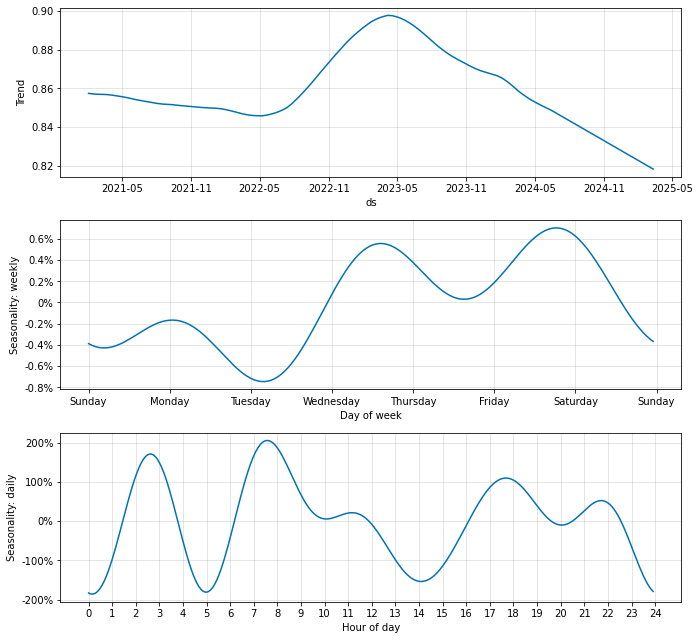

In [481]:
fig_com = nprophet.plot_components(forecast_data)

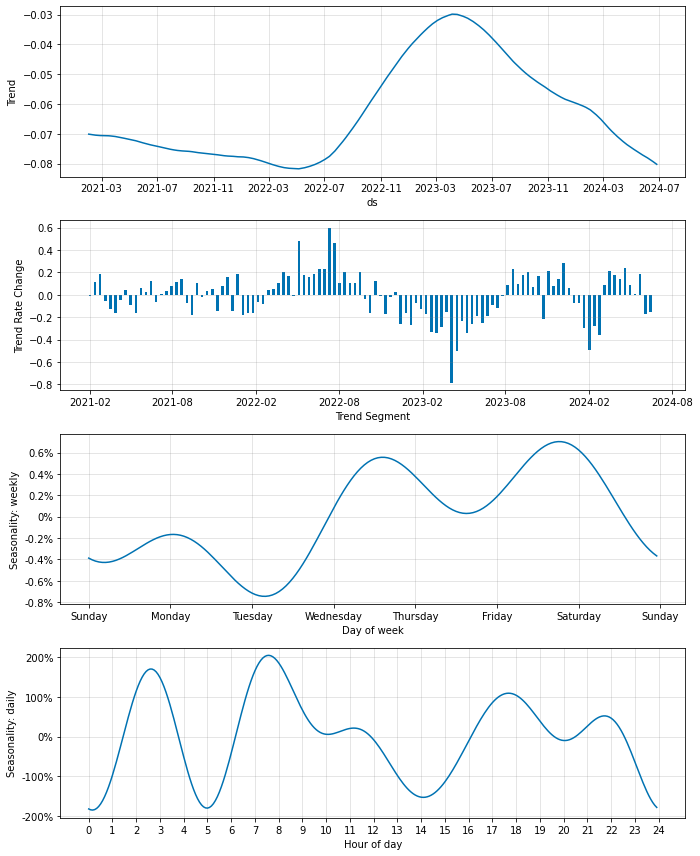

In [482]:
fig_param = nprophet.plot_parameters()

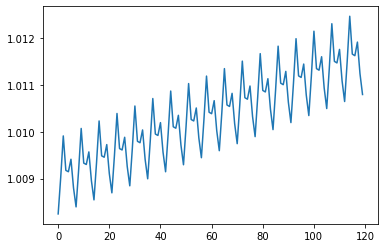

In [501]:
# plot_series(x_series[0], pred_y[0])
plt.plot(valid_pred_array[1])

In [554]:
def sell_10min(x_array):
    
    sell_timing = []
    selling = np.argmax(x_array, axis = 1)
    
    for idx in range(len(x_array[:,1])):
        if (selling[idx] >= 0 and selling[idx] < 2):
            sell_timing.append(np.argmax(x_array[idx, 2:])+2)
        else:
            sell_timing.append(selling[idx])
    return sell_timing

In [555]:
selling = np.argmax(x_array, axis = 1)
selling

array([0, 1, 2, 2, 3, 4])

In [556]:
x_array = [[1,0,0,0,0],[0,1,0,0,0], [0,0,1,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]]
x_array = np.array(x_array)
a = sell_10min(x_array)
a

[2, 2, 2, 2, 3, 4]

In [535]:
x_array.shape

(6, 5)

In [540]:
range(len(x_array[:,1]))

range(0, 6)

In [538]:
valid_pred_array.shape

(300, 120)

### <3> valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [484]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    sell = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
        
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.05) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
#     submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission['sell_time'] = sell_10min(pred_array)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [485]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [486]:
valid_submission.buy_quantity.value_counts()

0    252
1     48
Name: buy_quantity, dtype: int64

In [487]:
valid_submission[valid_submission['buy_quantity']==1]['sell_time'].value_counts()

118    16
119    16
117    13
114     2
116     1
Name: sell_time, dtype: int64

In [488]:
valid_submission.head()

,sample_id,buy_quantity,sell_time
0,0,0,1
1,1,0,114
2,2,0,0
3,3,0,119
4,4,0,0


In [500]:
import time
import numpy as np
import pandas as pd

df = pd.DataFrame(valid_submission)
df.to_csv(data_path+"/valid_pred_array_{}.csv".format(time.strftime('%H%M%S')), index = False)

### <4> 투자 후 금액 계산하기

In [489]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [490]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

sample 300~600 : 6968.529690636403

In [491]:
# 투자 후 금액
print(total_momey)

7162.445411976421


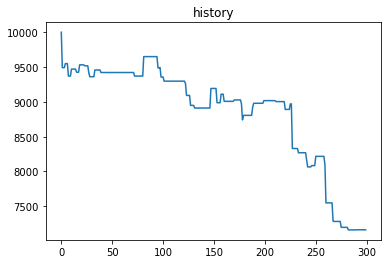

In [492]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

# 4. test 데이터 학습하고 추론하기

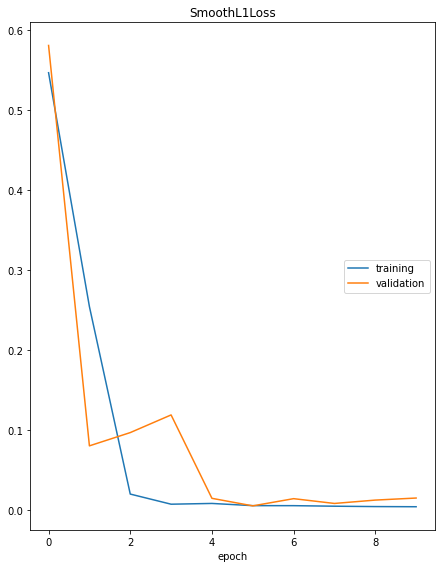


100%|██████████| 529/529 [15:39<00:00,  1.78s/it]


In [493]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])

for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(days = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()
    
        nprophet = NeuralProphet(yearly_seasonality=False, 
            weekly_seasonality=True, daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
            growth='logistic', seasonality_mode='additive', 
            trend_reg=trend_reg
        )


        nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, 
                        valid_p=0.1)


        nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
        # 120분 테스트 데이터를 예측합니다.
        future_data = nprophet.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
        forecast_data = nprophet.predict(future_data)

        pred_y = forecast_data.yhat1.values[-120:]
        trend = forecast_data.trend.values[-120:]
        residual = forecast_data.residual1.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

In [494]:
x_df

,ds,y
0,2021-02-01,0.994208
1,2021-02-02,0.994584
2,2021-02-03,0.992628
3,2021-02-04,0.996615
4,2021-02-05,0.994734
...,...,...
1375,2024-11-07,1.001805
1376,2024-11-08,0.998571
1377,2024-11-09,0.999323
1378,2024-11-10,1.000903


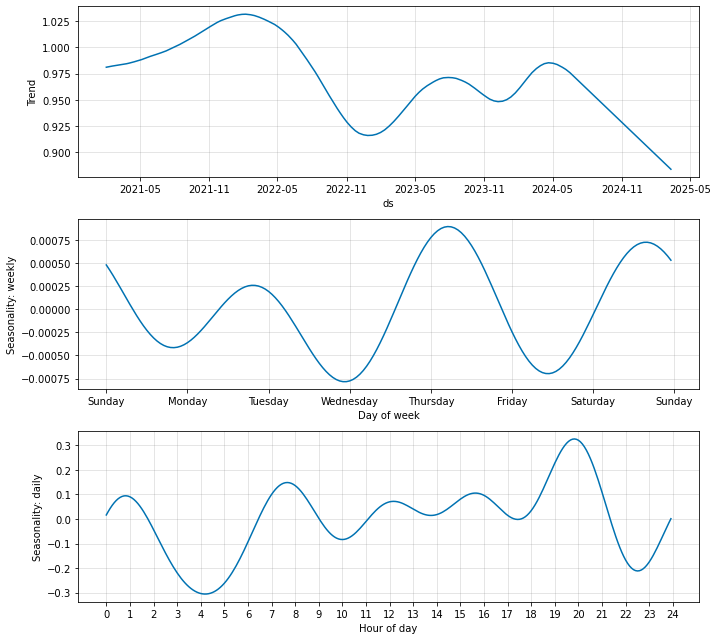

In [495]:
fig_comp = nprophet.plot_components(forecast_data)

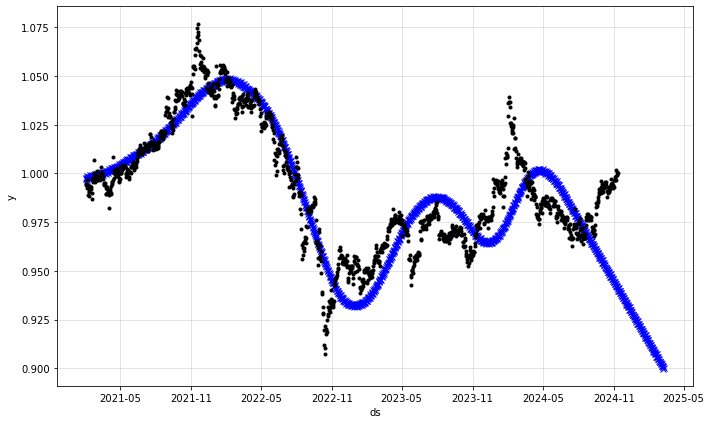

In [496]:
from fbprophet.plot import add_changepoints_to_plot

fig = nprophet.plot(forecast_data)

## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [497]:
import time
import numpy as np
import pandas as pd

df = pd.DataFrame(test_pred_array)
df.to_csv(data_path+"/pred_array_{}.csv".format(time.strftime('%H%M%S')), index = False)
print(df)

          0         1         2         3         4         5         6    \
0    1.025542  1.025748  1.025785  1.025962  1.026257  1.026367  1.026477   
1    1.031920  1.032308  1.032043  1.032372  1.032381  1.032638  1.032676   
2    1.115949  1.117159  1.118292  1.117665  1.119807  1.120147  1.122334   
3    1.037616  1.037320  1.038547  1.038764  1.038689  1.039118  1.039677   
4    0.964828  0.964632  0.964428  0.964197  0.964228  0.964171  0.963707   
..        ...       ...       ...       ...       ...       ...       ...   
524  1.005777  1.005530  1.004987  1.005227  1.005973  1.006250  1.006085   
525  1.032111  1.032118  1.032328  1.032450  1.032527  1.032741  1.033147   
526  0.976372  0.976203  0.976027  0.975881  0.975651  0.975347  0.975160   
527  1.009110  1.009440  1.009246  1.009174  1.009044  1.009033  1.009386   
528  0.941107  0.939795  0.941000  0.939636  0.939479  0.939670  0.938485   

          7         8         9    ...       110       111       112  \
0  

In [498]:
test_pred_array.shape

(529, 120)

In [499]:
submission = array_to_submission(test_x_array, test_pred_array)

In [270]:
submission

,sample_id,buy_quantity,sell_time
0,0,1,117
1,1,0,1
2,2,1,115
3,3,0,119
4,4,0,117
...,...,...,...
524,524,1,116
525,525,1,119
526,526,1,118
527,527,1,117


In [271]:
import time

# submission.to_csv(data_path+"/nproh_{}.csv".format(time.strftime('%H%M%S')), index = False)

In [273]:
submission.to_csv(data_path+"/n_changepoints={}_trend_reg={}_{}.csv".format(n_changepoints, trend_reg, time.strftime('%H%M%S')), index = False)

In [274]:
submission[submission['sell_time']!=0]['sell_time']

0      117
1        1
2      115
3      119
4      117
      ... 
524    116
525    119
526    118
527    117
528    116
Name: sell_time, Length: 509, dtype: int64

In [275]:
submission.buy_quantity.value_counts()

1    295
0    234
Name: buy_quantity, dtype: int64

In [276]:
submission[submission['buy_quantity']==1]['sell_time'].value_counts()

118    43
114    38
116    35
119    33
113    30
117    26
115    25
1      13
5      11
3      10
0       9
6       9
2       8
4       5
Name: sell_time, dtype: int64